In [ ]:
# # Uninstall the current Gym version
!pip uninstall -y gym

# # Install Gym version 0.23.1
!pip install gym==0.23.1

# # Restart the runtime after installation (necessary in some environments like Colab)
import os
os._exit(00)


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701367 sha256=a4890a6fd71304b798995d6939581e8b132813f698df9d0d2af986c10af51e25
  Stored in directory: /root/.cache/pip/wheels/1a/00/fb/fe5cf2860fb9b7bc860e28f00095a1f42c7b726dd6f42d1acc
Successfully built gym


In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 11100 (delta 928), reused 896 (delta 896), pack-reused 10098 (from 1)
Receiving objects: 100% (11100/11100), 8.17 MiB | 6.84 MiB/s, done.
Resolving deltas: 100% (8333/8333), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Running setup.py develop for neurogym


In [ ]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import pdb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlasticCTRNN(nn.Module):
    """Continuous-time RNN with context-gated plasticity."""

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau_x = 200  # Plasticity time constant for x
        self.tau_u = 1500  # Plasticity time constant for u
        self.tau = 100  # Time constant for hidden activity
        self.U = 0.15  # Baseline plasticity modulation
        self.dt = dt

        # Time step coefficients
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
            alpha_u = dt / self.tau_u
            alpha_x = dt / self.tau_x
        self.alpha = alpha
        self.alpha_u = alpha_u
        self.alpha_x = alpha_x

        # Input-to-hidden and hidden-to-hidden layers
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Context gating layers
        self.context_gate_u = nn.Linear(input_size + hidden_size, hidden_size)
        self.context_gate_x = nn.Linear(input_size + hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            batch_size = input.shape[1]
            device = input.device
            hidden = self.init_hidden(input.shape).to(device)
            hidden_u = torch.zeros(batch_size, self.hidden_size, device=device)
            hidden_x = torch.ones(batch_size, self.hidden_size, device=device)

        output = []
        for i in range(input.size(0)):
            hidden, hidden_u, hidden_x = self.recurrence(input[i], hidden, hidden_u, hidden_x)
            output.append(hidden)

        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

    def recurrence(self, input, hidden, hidden_u, hidden_x):
        """Run network for one time step."""
        batch_size = input.size(0)

        # Calculate the context gating terms
        context_input = torch.cat([input, hidden], dim=1)  # Combine input and hidden state
        gate_u = torch.sigmoid(self.context_gate_u(context_input))  # Gate for hidden_u
        gate_x = torch.sigmoid(self.context_gate_x(context_input))  # Gate for hidden_x

        # Modulate plasticity components with context gates
        hidden_plasticity = hidden * hidden_x * hidden_u * gate_u

        # Compute the next hidden state
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden_plasticity))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha

        # Update plasticity terms with context gating
        dx = (1 - hidden_x) * self.alpha_x - hidden_plasticity * self.dt
        hidden_x_new = torch.clamp(hidden_x + dx * gate_x, min=0, max=1)

        du = (self.U - hidden_u) * self.alpha_u - self.U * (1 - hidden_u) * hidden * self.dt
        hidden_u_new = torch.clamp(hidden_u + du * gate_u, min=0, max=1)

        return h_new, hidden_u_new, hidden_x_new


class PlasticRNNNet(nn.Module):
    """Recurrent network model with plasticity."""

    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.rnn = PlasticCTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output


In [ ]:
import torch

# Determine dimension of outputs and inputs
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Initialize the PlasticRNNNet (which uses PlasticCTRNN)
rnn = PlasticRNNNet(input_size=input_size, hidden_size=100, output_size=10, dt=0.1)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape =', input_rnn.shape)
print('Output of shape =', out.shape)


Input of shape = torch.Size([20, 16, 5])
Output of shape = torch.Size([20, 16, 10])


In [ ]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym

task_name = 'PerceptualDecisionMaking-v0'

# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}


In [ ]:
# Make supervised dataset
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)


In [ ]:
# Instantiate the network and print information
hidden_size = 128
net = PlasticRNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()

    loss_values = []
    # Loop over training batches
    print('Training network...')
    for i in range(2000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)
            running_loss = 0
    return net, loss_values



trained_model = {}
loss_dict = {}

trained_model['Plastic'], loss_dict['Plastic'] = train_model(net, dataset)

PlasticRNNNet(
  (rnn): PlasticCTRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
    (context_gate_u): Linear(in_features=131, out_features=128, bias=True)
    (context_gate_x): Linear(in_features=131, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.2371, Time 17.3s
Step 200, Loss 0.1176, Time 32.9s
Step 300, Loss 0.0996, Time 48.3s
Step 400, Loss 0.0861, Time 63.8s
Step 500, Loss 0.0746, Time 80.4s
Step 600, Loss 0.0655, Time 96.3s
Step 700, Loss 0.0596, Time 111.7s
Step 800, Loss 0.0512, Time 127.1s
Step 900, Loss 0.0493, Time 143.7s
Step 1000, Loss 0.0464, Time 159.1s
Step 1100, Loss 0.0470, Time 175.1s
Step 1200, Loss 0.0426, Time 195.0s
Step 1300, Loss 0.0410, Time 210.2s
Step 1400, Loss 0.0409, Time 225.9s
Step 1500, Loss 0.0390, Time 241.1s
Step 1600, Loss 0.0388, Time 257.6s
Step 1700, Loss 0.0390, Time 273.0s


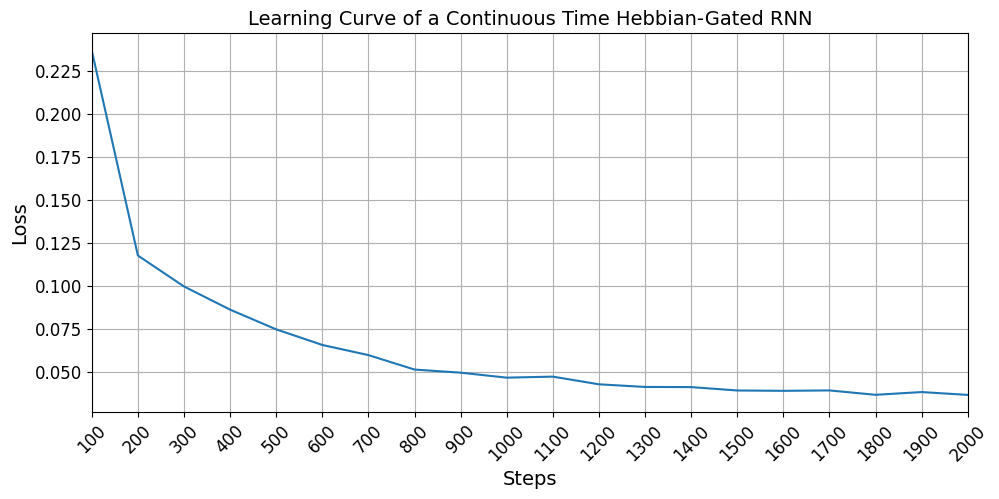

For standard leaky RNN
Trial  0 {'ground_truth': 0, 'coh': 25.6, 'correct': True, 'choice': 1}
Trial  1 {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}
Trial  2 {'ground_truth': 0, 'coh': 0.0, 'correct': True, 'choice': 1}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True, 'choice': 2}
Trial  4 {'ground_truth': 0, 'coh': 6.4, 'correct': True, 'choice': 1}
Average performance 0.855


In [ ]:
#@title Plotting the learning curves
# Set the default font to a safer option (like DejaVu Sans)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plotting the learning curve
plt.figure(figsize=(10,5))
for name, loss_values in loss_dict.items():
  steps = np.arange(100, 100 * (len(loss_values) + 1), 100)
  plt.plot(steps, loss_values, label=f'{name} Network')
plt.title("Learning Curve of a Continuous Time Hebbian-Gated RNN", fontsize=14)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(steps, rotation=45)
plt.xlim(steps[0], steps[-1])
plt.tight_layout()

plt.show()


# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information
stim_activity = [[], []]  # response for ground-truth 0 and 1

num_trial = 200
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

# Print information for sample trials standard
print('For standard leaky RNN')
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Shape of the neural activity (Time points, Neurons): (12000, 128)
Shape of the projected activity for PCA (Time points, PCs): (12000, 2)


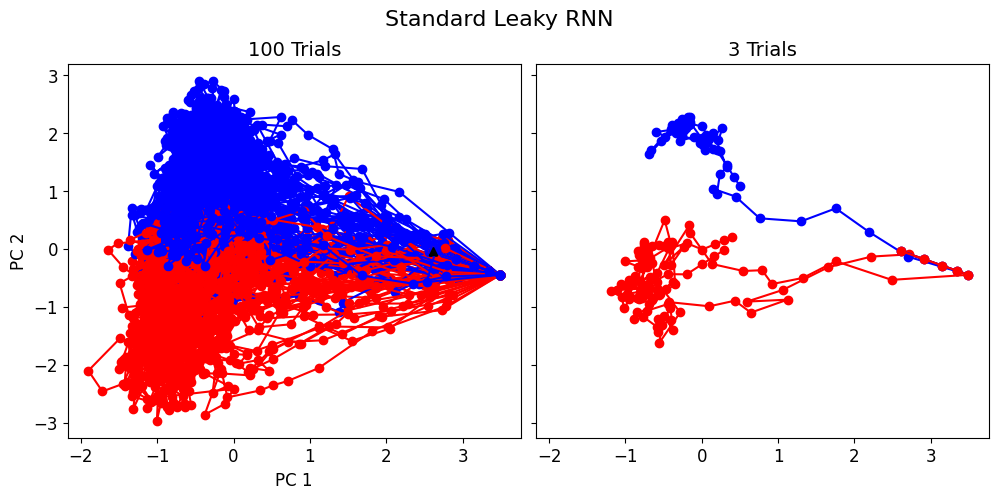

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA and fit it on the activity data
activity = np.concatenate([activity_dict[i] for i in range(len(activity_dict))], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity for PCA (Time points, PCs):', activity_pc.shape)

def plot_trials(activity_dict, trial_infos, plot_until_time, title, ax1_title, ax2_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):  # Limit the number of trials plotted
        # Transform and plot each trial's activity
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i] if i < len(trial_infos) else {}
        color = 'red' if trial.get('ground_truth', None) == 0 else 'blue'  # Safely access 'ground_truth'

        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 3:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles with larger font sizes
    ax1.set_title(ax1_title, fontsize=14)
    ax2.set_title(ax2_title, fontsize=14)
    ax1.set_xlabel('PC 1', fontsize=12)
    ax1.set_ylabel('PC 2', fontsize=12)

    # Adjust tick label sizes
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # Set the overall title with larger font size
    plt.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Now plot for the task at hand
plot_trials(activity_dict=activity_dict, trial_infos=trial_infos, plot_until_time=70,
            title="Standard Leaky RNN", ax1_title="100 Trials", ax2_title="3 Trials")

